In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import polars as pl
import numpy as np


In [10]:
ds = xr.open_dataset(Path("../data_original/spectra_coh_LES.nc"))

In [11]:
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (radius: 1, height: 60, frequency: 3001,
                         spatialSeparation: 26, frequency_coh: 221)
Coordinates:
  * radius              (radius) float64 8B 0.9798
  * height              (height) float64 480B 1.974 6.413 11.34 ... 285.7 290.6
  * frequency           (frequency) float64 24kB 0.0 0.001667 ... 4.998 5.0
  * spatialSeparation   (spatialSeparation) float64 208B 0.0 11.11 ... 179.5
  * frequency_coh       (frequency_coh) float64 2kB 0.0 0.004539 ... 0.9986
Data variables:
    spectralDensity_u   (radius, height, frequency) float64 1MB ...
    spectralDensity_v   (radius, height, frequency) float64 1MB ...
    spectralDensity_w   (radius, height, frequency) float64 1MB ...
    spectralDensity_uu  (radius, height, frequency) float64 1MB ...
    spectralDensity_vv  (radius, height, frequency) float64 1MB ...
    spectralDensity_ww  (radius, height, frequency) float64 1MB ...
    spectralDensity_uw  (radius, height, f

In [12]:
# Coordinates for spectra
radius_ds = np.array(ds['radius'])
height_ds = np.array(ds['height'])
freq_ds = np.array(ds['frequency'])

fUU_ds = np.array(ds['spectralDensity_uu'])
fVV_ds = np.array(ds['spectralDensity_vv'])
fWW_ds = np.array(ds['spectralDensity_ww'])
fUW_ds = np.array(ds['spectralDensity_uw'])
fUV_ds = np.array(ds['spectralDensity_uv'])
fVW_ds = np.array(ds['spectralDensity_vw'])


In [13]:
fUU_ds.shape

(1, 60, 3001)

In [15]:
# Grab a particular height
height = len(height_ds) // 2

# Get spectra at that height
freq_h = freq_ds.copy()
fUU_h = np.squeeze(fUU_ds[0, height, :])
fVV_h = np.squeeze(fVV_ds[0, height, :])
fWW_h = np.squeeze(fWW_ds[0, height, :])
fUW_h = np.squeeze(fUW_ds[0, height, :])
fUV_h = np.squeeze(fUV_ds[0, height, :])
fVW_h = np.squeeze(fVW_ds[0, height, :])


In [16]:
print(height_ds[height])

148.56202535609793


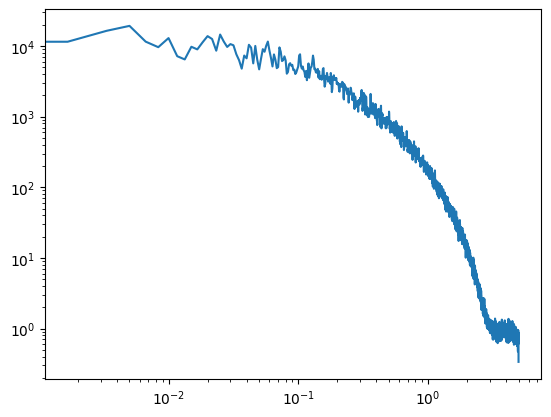

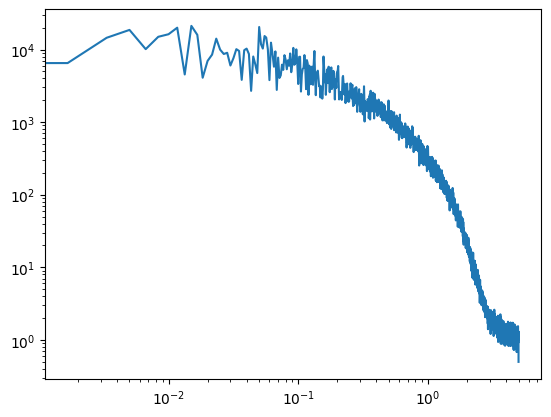

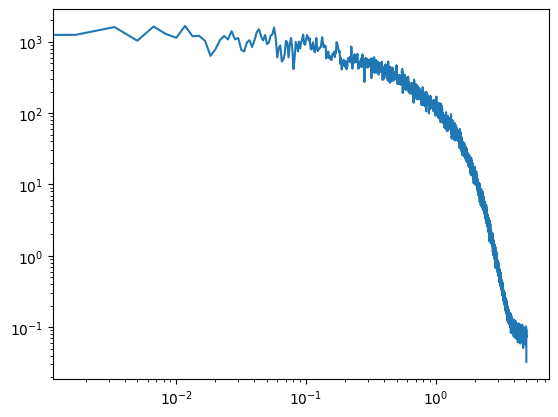

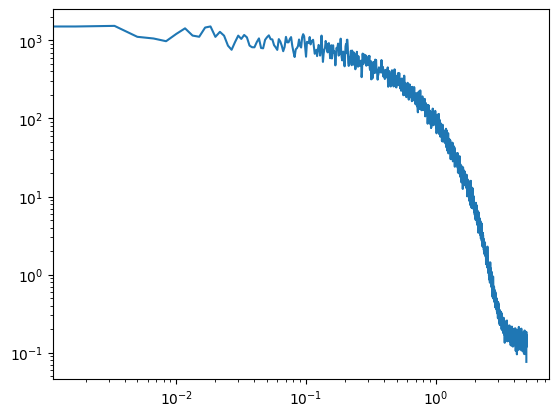

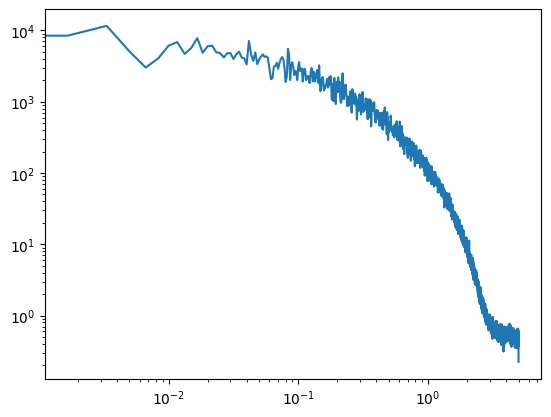

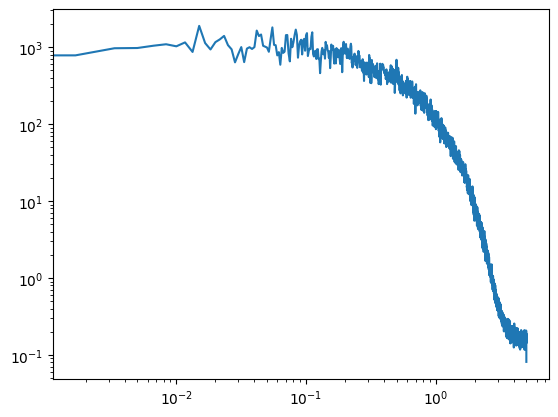

In [17]:
plt.loglog(freq_h, fUU_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fVV_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fWW_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fUW_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fUV_h)
plt.show()
plt.figure()
plt.loglog(freq_h, fVW_h)
plt.show()





In [18]:
# NOTE: Copied from older data_clean.ipynb
def clean_spectra(
    frequency,
    uu,
    vv,
    ww,
    uw,
    vw,
    uv,
    threshold=1.0,
    buffer_points=10
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Clean all spectral components using a common cutoff point.
    
    Parameters
    ----------
    frequency : np.ndarray
        The frequency values (3001,)
    uu, vv, ww, uw : np.ndarray
        The spectral components (each 3001,)
    threshold : float, optional
        The threshold value below which to cut off (default: 1.0)
    buffer_points : int, optional
        Number of points to keep before the cutoff for smooth transition
        
    Returns
    -------
    cleaned_freq : np.ndarray
        The cleaned frequency array
    cleaned_uu, cleaned_vv, cleaned_ww, cleaned_uw : np.ndarray
        The cleaned spectral components
    """
    # Find where each component drops below threshold
    cutoff_idx_uu = np.where(uu < threshold)[0][0] if np.any(uu < threshold) else len(uu)
    cutoff_idx_vv = np.where(vv < threshold)[0][0] if np.any(vv < threshold) else len(vv)
    cutoff_idx_ww = np.where(ww < threshold)[0][0] if np.any(ww < threshold) else len(ww)
    
    # For uw (cross-spectrum), use absolute value since it can be negative
    cutoff_idx_uw = np.where(np.abs(uw) < threshold/10)[0][0] if np.any(np.abs(uw) < threshold/10) else len(uw)
    cutoff_idx_vw = np.where(np.abs(vw) < threshold/10)[0][0] if np.any(np.abs(vw) < threshold/10) else len(vw)
    cutoff_idx_uv = np.where(np.abs(uv) < threshold/10)[0][0] if np.any(np.abs(uv) < threshold/10) else len(uv)
    
    # Take the earliest cutoff point to ensure all spectra are valid
    cutoff_idx = min(
        cutoff_idx_uu,
        cutoff_idx_vv,
        cutoff_idx_ww,
        cutoff_idx_uw,
        cutoff_idx_vw,
        cutoff_idx_uv
    )
    
    # Add buffer
    final_idx = max(0, cutoff_idx - buffer_points)
    
    # Return cleaned arrays
    return (frequency[:final_idx],
            uu[:final_idx],
            vv[:final_idx],
            ww[:final_idx],
            uw[:final_idx],
            vw[:final_idx],
            uv[:final_idx])

In [19]:
cleaned_freq_spectra = clean_spectra(
    frequency=freq_h,
    uu=fUU_h,
    vv=fVV_h,
    ww=fWW_h,
    uw=fUW_h,
    vw=fVW_h,
    uv=fUV_h
)

In [20]:
cfreq_h = cleaned_freq_spectra[0]
cfUU_h = cleaned_freq_spectra[1]
cfVV_h = cleaned_freq_spectra[2]
cfWW_h = cleaned_freq_spectra[3]
cfUW_h = cleaned_freq_spectra[4]
cfVW_h = cleaned_freq_spectra[5]
cfUV_h = cleaned_freq_spectra[6]

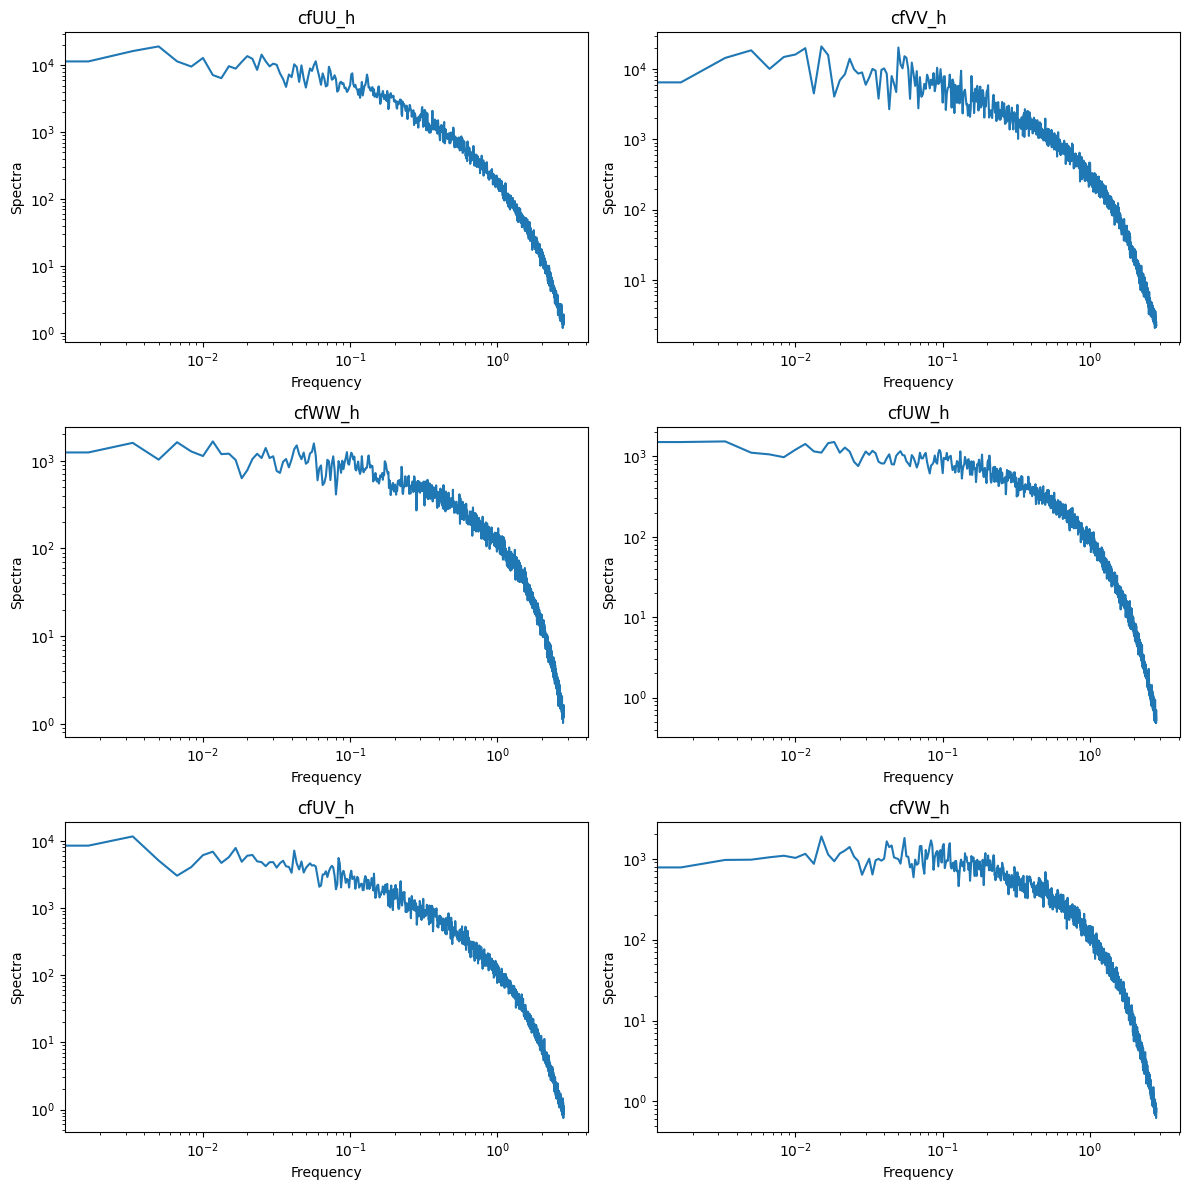

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].loglog(cfreq_h, cfUU_h)
axs[0, 0].set_title('cfUU_h')
axs[0, 0].set_ylabel('Spectra')
axs[0, 0].set_xlabel('Frequency')

axs[0, 1].loglog(cfreq_h, cfVV_h)
axs[0, 1].set_title('cfVV_h')
axs[0, 1].set_ylabel('Spectra')
axs[0, 1].set_xlabel('Frequency')

axs[1, 0].loglog(cfreq_h, cfWW_h)
axs[1, 0].set_title('cfWW_h')
axs[1, 0].set_ylabel('Spectra')
axs[1, 0].set_xlabel('Frequency')

axs[1, 1].loglog(cfreq_h, cfUW_h)
axs[1, 1].set_title('cfUW_h')
axs[1, 1].set_ylabel('Spectra')
axs[1, 1].set_xlabel('Frequency')

axs[2, 0].loglog(cfreq_h, cfUV_h)
axs[2, 0].set_title('cfUV_h')
axs[2, 0].set_ylabel('Spectra')
axs[2, 0].set_xlabel('Frequency')

axs[2, 1].loglog(cfreq_h, cfVW_h)
axs[2, 1].set_title('cfVW_h')
axs[2, 1].set_ylabel('Spectra')
axs[2, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()



In [22]:
weighted_uu = cfUU_h * cfreq_h
weighted_vv = cfVV_h * cfreq_h
weighted_ww = cfWW_h * cfreq_h
weighted_uw = cfUW_h * cfreq_h
weighted_vw = cfVW_h * cfreq_h
weighted_uv = cfUV_h * cfreq_h

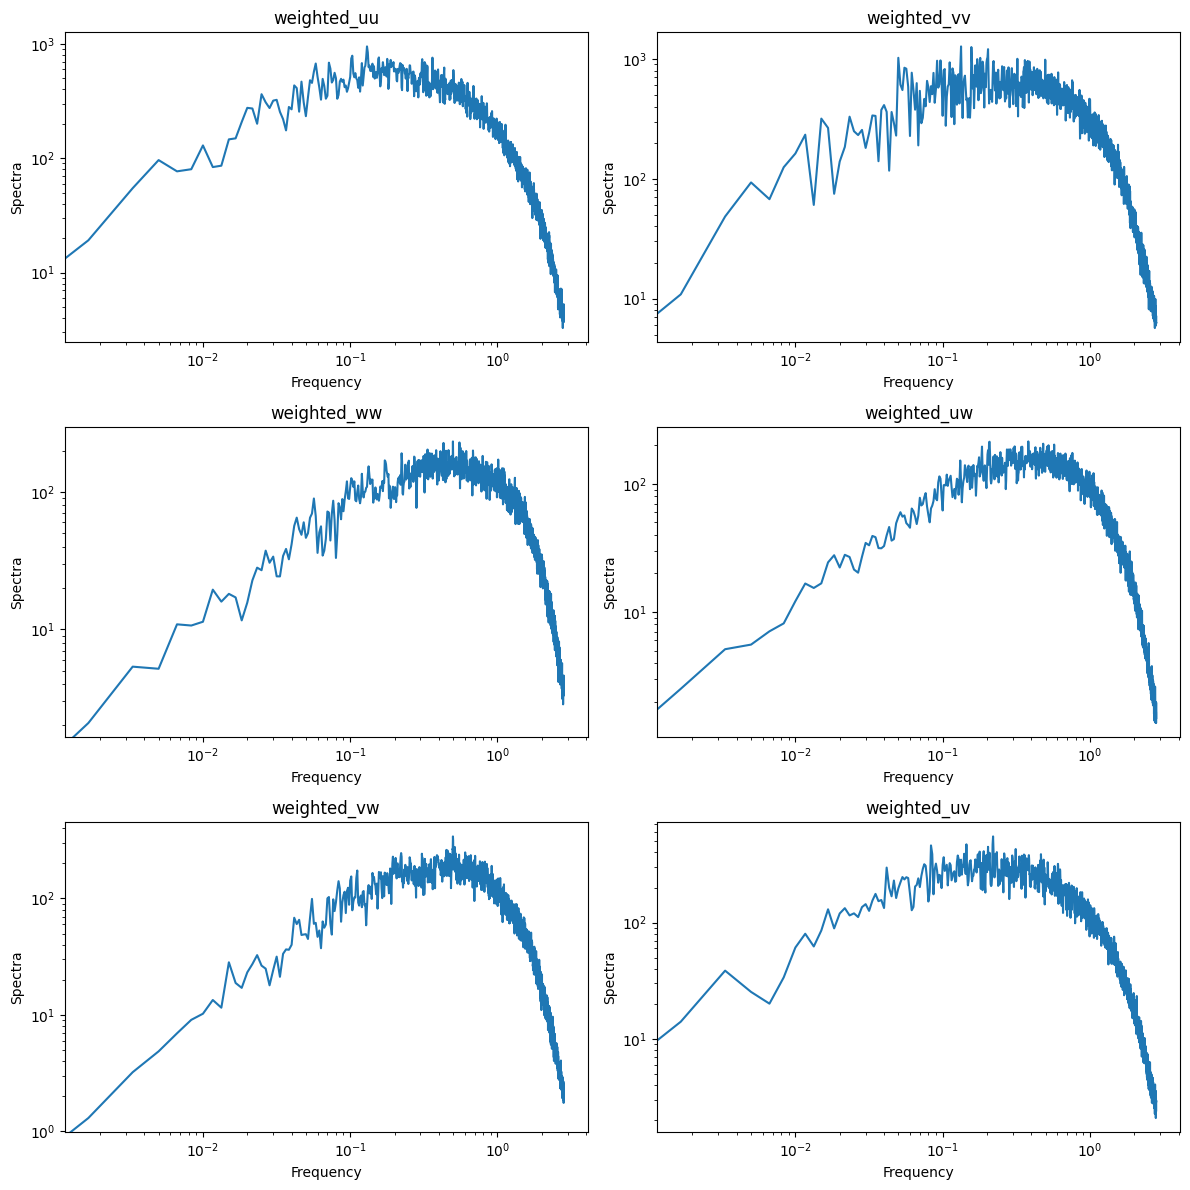

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

axs[0, 0].loglog(cfreq_h, weighted_uu)
axs[0, 0].set_title('weighted_uu')
axs[0, 0].set_ylabel('Spectra')
axs[0, 0].set_xlabel('Frequency')

axs[0, 1].loglog(cfreq_h, weighted_vv)
axs[0, 1].set_title('weighted_vv')
axs[0, 1].set_ylabel('Spectra')
axs[0, 1].set_xlabel('Frequency')

axs[1, 0].loglog(cfreq_h, weighted_ww)
axs[1, 0].set_title('weighted_ww')
axs[1, 0].set_ylabel('Spectra')
axs[1, 0].set_xlabel('Frequency')

axs[1, 1].loglog(cfreq_h, weighted_uw)
axs[1, 1].set_title('weighted_uw')
axs[1, 1].set_ylabel('Spectra')
axs[1, 1].set_xlabel('Frequency')

axs[2, 0].loglog(cfreq_h, weighted_vw)
axs[2, 0].set_title('weighted_vw')
axs[2, 0].set_ylabel('Spectra')
axs[2, 0].set_xlabel('Frequency')

axs[2, 1].loglog(cfreq_h, weighted_uv)
axs[2, 1].set_title('weighted_uv')
axs[2, 1].set_ylabel('Spectra')
axs[2, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [34]:
def log_downsample(freq, data_columns, points_per_decade=20):
    """Downsample data with logarithmic spacing."""
    # Ensure all inputs are numpy arrays
    freq = np.array(freq)
    data_arrays = [np.array(col) for col in data_columns]
    
    # Filter out any zero or negative values in frequency
    positive_mask = freq > 0
    if not np.all(positive_mask):
        freq = freq[positive_mask]
        data_arrays = [col[positive_mask] for col in data_arrays]
        
    # Calculate frequency decades (log10 ranges)
    min_freq, max_freq = np.min(freq), np.max(freq)
    
    # Add a small epsilon to min_freq to prevent log10(0)
    min_freq = max(min_freq, 1e-10)
    
    min_decade, max_decade = np.log10(min_freq), np.log10(max_freq)
    num_decades = max_decade - min_decade
    
    # Ensure num_decades is positive
    if num_decades <= 0:
        num_decades = 1.0  # Default to at least one decade
    
    # Calculate total number of points to keep
    total_points = int(np.ceil(points_per_decade * num_decades))
    
    # Ensure we have at least 2 points
    total_points = max(total_points, 2)
    
    # Create logarithmically spaced frequency points
    log_spaced_freq = np.logspace(min_decade, max_decade, total_points)
    
    # Find indices of original data points closest to these log-spaced points
    downsampled_indices = []
    for target_freq in log_spaced_freq:
        idx = np.argmin(np.abs(freq - target_freq))
        if idx not in downsampled_indices:  # Avoid duplicates
            downsampled_indices.append(idx)
    
    # Sort indices
    downsampled_indices.sort()
    
    # Return downsampled frequency and data arrays
    downsampled_freq = freq[downsampled_indices]
    downsampled_data = [col[downsampled_indices] for col in data_arrays]
    
    return downsampled_freq, downsampled_data

downsampled_freq, downsampled_data = log_downsample(
    cfreq_h, 
    [weighted_uu, weighted_vv, weighted_ww, weighted_uw, weighted_vw, weighted_uv],
    points_per_decade=80  # Adjust this
)

In [35]:
downsampled_data_array = np.column_stack([downsampled_freq] + downsampled_data)

In [52]:
downsampled_data_array

array([[1.66666667e-03, 1.91400356e+01, 1.08466260e+01, ...,
        2.51355179e+00, 1.30175519e+00, 1.40821471e+01],
       [3.33333333e-03, 5.46785937e+01, 4.83989234e+01, ...,
        5.11835653e+00, 3.22217352e+00, 3.86386907e+01],
       [5.00000000e-03, 9.62775401e+01, 9.31369629e+01, ...,
        5.56046371e+00, 4.86627432e+00, 2.53791966e+01],
       ...,
       [2.66166667e+00, 6.41673960e+00, 9.32460185e+00, ...,
        2.54578722e+00, 2.34682958e+00, 3.94612156e+00],
       [2.74000000e+00, 4.78941577e+00, 8.87701111e+00, ...,
        2.09043626e+00, 2.52753286e+00, 3.13996101e+00],
       [2.82000000e+00, 4.33818787e+00, 6.25105896e+00, ...,
        1.48741615e+00, 2.12712963e+00, 2.91564066e+00]], shape=(170, 7))

In [56]:
ops_data_frame = pl.DataFrame(
    {
        "frequency": downsampled_freq,
        "uu": downsampled_data_array[:, 0],
        "vv": downsampled_data_array[:, 1],
        "ww": downsampled_data_array[:, 2],
        "uw": downsampled_data_array[:, 3],
        "vw": downsampled_data_array[:, 4],
        "uv": downsampled_data_array[:, 5],
    }
)


In [57]:
ops_data_frame.write_csv("STORM_80_ops_data.csv")

In [36]:
np.savetxt(
    '../data_cleaned/log_downsampled_6component_spectra.dat',
    downsampled_data_array,
    delimiter=","
)

In [37]:
downsampled_data_array

array([[1.66666667e-03, 1.91400356e+01, 1.08466260e+01, ...,
        2.51355179e+00, 1.30175519e+00, 1.40821471e+01],
       [3.33333333e-03, 5.46785937e+01, 4.83989234e+01, ...,
        5.11835653e+00, 3.22217352e+00, 3.86386907e+01],
       [5.00000000e-03, 9.62775401e+01, 9.31369629e+01, ...,
        5.56046371e+00, 4.86627432e+00, 2.53791966e+01],
       ...,
       [2.66166667e+00, 6.41673960e+00, 9.32460185e+00, ...,
        2.54578722e+00, 2.34682958e+00, 3.94612156e+00],
       [2.74000000e+00, 4.78941577e+00, 8.87701111e+00, ...,
        2.09043626e+00, 2.52753286e+00, 3.13996101e+00],
       [2.82000000e+00, 4.33818787e+00, 6.25105896e+00, ...,
        1.48741615e+00, 2.12712963e+00, 2.91564066e+00]], shape=(170, 7))

In [38]:
downsampled_freq = downsampled_data_array[:,0]
downsampled_uu = downsampled_data_array[:,1]
downsampled_vv = downsampled_data_array[:,2]
downsampled_ww = downsampled_data_array[:,3]
downsampled_uw = downsampled_data_array[:,4]
downsampled_vw = downsampled_data_array[:,5]
downsampled_uv = downsampled_data_array[:,6]


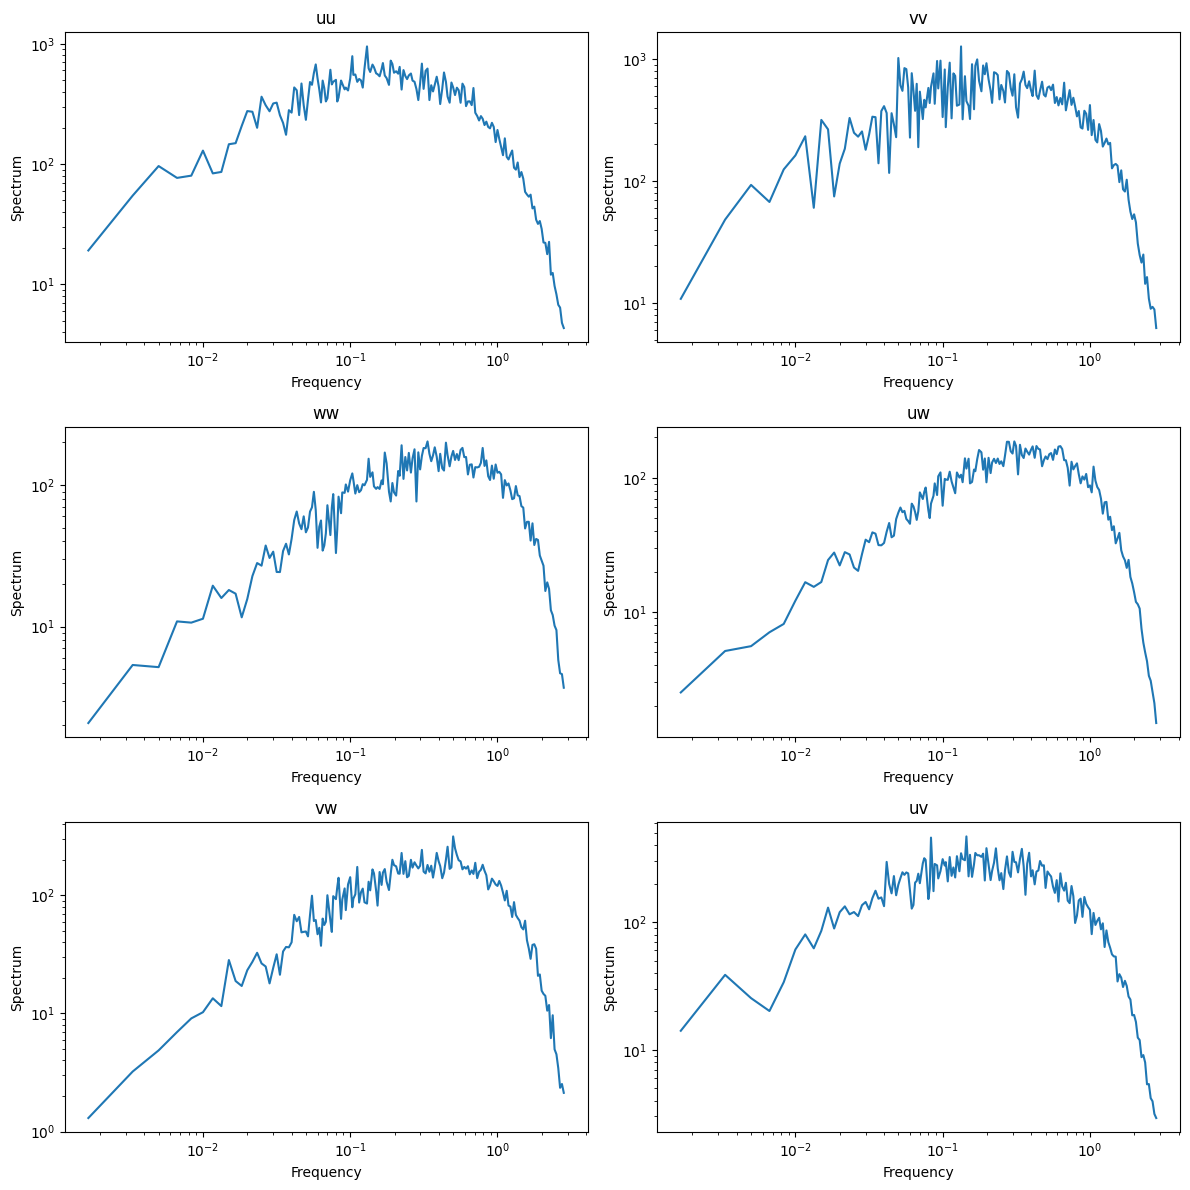

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

axes = axes.flatten()
components = [
    (downsampled_uu, "uu"),
    (downsampled_vv, "vv"),
    (downsampled_ww, "ww"),
    (downsampled_uw, "uw"),
    (downsampled_vw, "vw"),
    (downsampled_uv, "uv"),
]

for ax, (data, label) in zip(axes, components):
    ax.loglog(downsampled_freq, data)
    ax.set_title(label)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Spectrum")

plt.tight_layout()
plt.show()






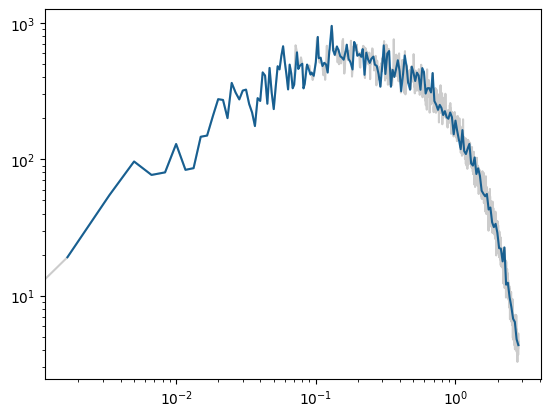

In [44]:
plt.loglog(downsampled_freq, downsampled_uu)
plt.loglog(cfreq_h, weighted_uu, color='k', alpha=0.2)
plt.show()

Fitting slopes for hurricane turbulence spectra:

Fitting UU spectrum:
  Frequency range: 1.6927 to 2.6791
  Points in fitting range: 592
  Result: Slope = -4.974, R² = 0.947

Fitting VV spectrum:
  Frequency range: 1.6927 to 2.6791
  Points in fitting range: 592
  Result: Slope = -5.248, R² = 0.957

Fitting WW spectrum:
  Frequency range: 1.6927 to 2.6791
  Points in fitting range: 592
  Result: Slope = -4.881, R² = 0.944
  Frequency range: 1.6927 to 2.6791
  Points in fitting range: 592
  Frequency range: 1.6927 to 2.6791
  Points in fitting range: 592
  Frequency range: 1.6927 to 2.6791
  Points in fitting range: 592


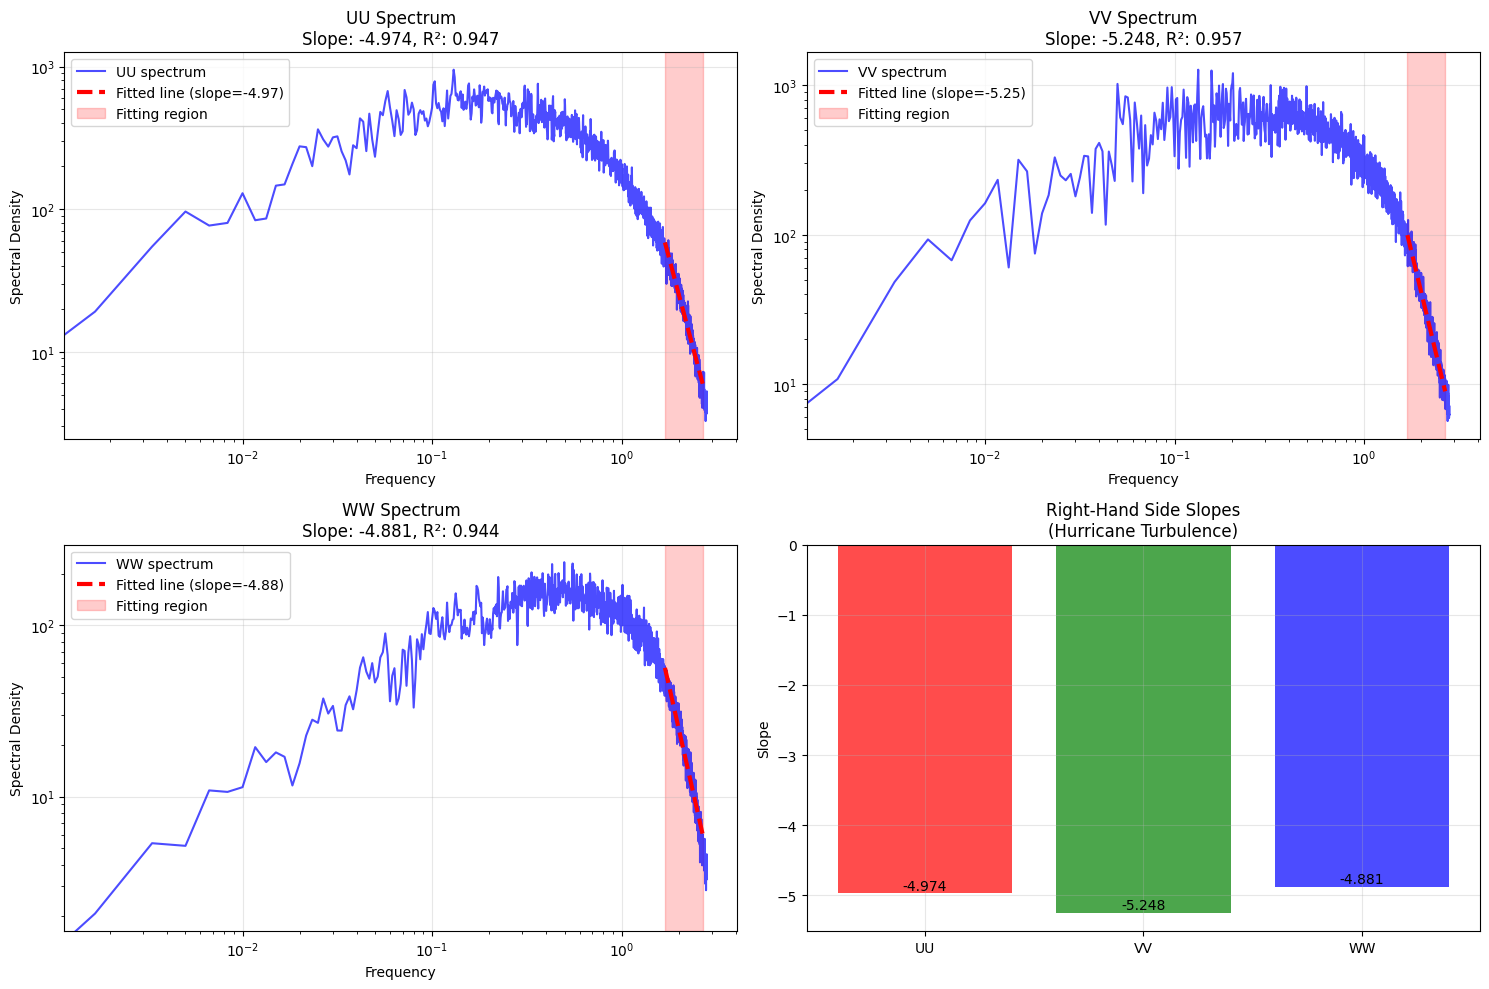


SUMMARY - Right-Hand Side Slopes:
UU :  -4.974 (R² = 0.947)
VV :  -5.248 (R² = 0.957)
WW :  -4.881 (R² = 0.944)

Note: These slopes represent the scaling behavior
in the right-hand side of your hurricane turbulence spectra.


In [ ]:
from scipy import stats


def fit_rhs_line(frequency, spectrum, start_freq_ratio=0.6, end_freq_ratio=0.95, min_points=10):
    
    valid_mask = np.isfinite(frequency) & np.isfinite(spectrum) & (spectrum > 0) & (frequency > 0)
    freq_clean = frequency[valid_mask]
    spec_clean = spectrum[valid_mask]
    
    if len(freq_clean) < min_points:
        raise ValueError(f"Not enough valid data points: {len(freq_clean)}")
    
    log_freq = np.log10(freq_clean)
    log_spectrum = np.log10(spec_clean)
    
    freq_range = np.percentile(log_freq, [start_freq_ratio*100, end_freq_ratio*100])
    start_freq, end_freq = freq_range[0], freq_range[1]
    
    mask = (log_freq >= start_freq) & (log_freq <= end_freq)
    n_points = np.sum(mask)
    
    print(f"  Frequency range: {10**start_freq:.4f} to {10**end_freq:.4f}")
    print(f"  Points in fitting range: {n_points}")
    
    if n_points < min_points:
        raise ValueError(f"Not enough points for fitting. Found {n_points}, need at least {min_points}")
    
    log_freq_fit = log_freq[mask]
    log_spectrum_fit = log_spectrum[mask]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_freq_fit, log_spectrum_fit)
    
    return slope, intercept, r_value**2, 10**log_freq_fit, 10**log_spectrum_fit

slopes = {}
r_squared = {}

print("Fitting slopes for hurricane turbulence spectra:")
print("=" * 50)

# Fit each spectrum component
for name, spectrum in [('UU', weighted_uu), ('VV', weighted_vv), ('WW', weighted_ww)]:
    print(f"\nFitting {name} spectrum:")
    try:
        slope, intercept, r2, freq_fit, spec_fit = fit_rhs_line(cfreq_h, spectrum)
        slopes[name] = slope
        r_squared[name] = r2
        
        print(f"  Result: Slope = {slope:.3f}, R² = {r2:.3f}")
        
    except ValueError as e:
        print(f"  Error fitting {name}: {e}")

# Create visualization
plt.figure(figsize=(15, 10))

for i, (name, spectrum) in enumerate([('UU', weighted_uu), ('VV', weighted_vv), ('WW', weighted_ww)]):
    plt.subplot(2, 2, i+1)
    
    # Plot original spectrum
    plt.loglog(cfreq_h, spectrum, 'b-', alpha=0.7, label=f'{name} spectrum', linewidth=1.5)
    
    try:
        # Fit and plot line
        slope, intercept, r2, freq_fit, spec_fit = fit_rhs_line(cfreq_h, spectrum)
        
        # Create fitted line for visualization
        line_spectrum = 10**(intercept + slope * np.log10(freq_fit))
        plt.loglog(freq_fit, line_spectrum, 'r--', linewidth=3, 
                  label=f'Fitted line (slope={slope:.2f})')
        
        # Highlight the fitting region
        plt.axvspan(freq_fit.min(), freq_fit.max(), alpha=0.2, color='red', 
                   label='Fitting region')
        
        plt.title(f'{name} Spectrum\nSlope: {slope:.3f}, R²: {r2:.3f}')
        
    except ValueError:
        plt.title(f'{name} Spectrum\n(Fitting failed)')
    
    plt.xlabel('Frequency')
    plt.ylabel('Spectral Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Add a summary plot
plt.subplot(2, 2, 4)
if slopes:
    names = list(slopes.keys())
    slope_values = [slopes[name] for name in names]
    colors = ['red', 'green', 'blue'][:len(names)]
    
    bars = plt.bar(names, slope_values, color=colors, alpha=0.7)
    plt.ylabel('Slope')
    plt.title('Right-Hand Side Slopes\n(Hurricane Turbulence)')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, slope_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*50)
print("SUMMARY - Right-Hand Side Slopes:")
print("="*50)
for name in ['UU', 'VV', 'WW']:
    if name in slopes:
        print(f"{name:3s}: {slopes[name]:7.3f} (R² = {r_squared[name]:.3f})")
    else:
        print(f"{name:3s}: Fitting failed")

print(f"\nNote: These slopes represent the scaling behavior")
print(f"in the right-hand side of your hurricane turbulence spectra.")

# Coherence Data

In [32]:
import polars
import numpy as np

In [45]:
print(ds)

<xarray.Dataset> Size: 13MB
Dimensions:             (radius: 1, height: 60, frequency: 3001,
                         spatialSeparation: 26, frequency_coh: 221)
Coordinates:
  * radius              (radius) float64 8B 0.9798
  * height              (height) float64 480B 1.974 6.413 11.34 ... 285.7 290.6
  * frequency           (frequency) float64 24kB 0.0 0.001667 ... 4.998 5.0
  * spatialSeparation   (spatialSeparation) float64 208B 0.0 11.11 ... 179.5
  * frequency_coh       (frequency_coh) float64 2kB 0.0 0.004539 ... 0.9986
Data variables:
    spectralDensity_u   (radius, height, frequency) float64 1MB ...
    spectralDensity_v   (radius, height, frequency) float64 1MB ...
    spectralDensity_w   (radius, height, frequency) float64 1MB ...
    spectralDensity_uu  (radius, height, frequency) float64 1MB 2.215e+03 ......
    spectralDensity_vv  (radius, height, frequency) float64 1MB 534.9 ... 0.8316
    spectralDensity_ww  (radius, height, frequency) float64 1MB 0.01027 ... 0...
   

In [49]:
spatialSeparation_ds = np.array(ds['spatialSeparation'])[4:]
coh_freq_ds = np.array(ds['frequency_coh'])

coh_u_alongCross_ds = np.array(ds['coh_u_alongCross'])[4:,:]
coh_v_alongCross_ds = np.array(ds['coh_v_alongCross'])[4:,:]
coh_w_alongCross_ds = np.array(ds['coh_w_alongCross'])[4:,:]

In [50]:
print(np.any(np.isnan(coh_u_alongCross_ds)))
print(np.any(np.isnan(coh_v_alongCross_ds)))
print(np.any(np.isnan(coh_w_alongCross_ds)))

False
False
False


In [51]:
print(spatialSeparation_ds)

[ 40.06167931  45.81228298  49.6903976   59.83516224  74.53559641
  80.8901068   84.61969795  91.62456596  99.38079521 105.40925132
 109.43174918 116.00340123 119.67032448 126.68615351 130.05221627
 134.25606125 144.44443893 151.12744433 154.75986384 161.78021359
 169.2393959  179.50548672]


In [31]:
print(coh_u_alongCross_ds.shape)
print(coh_v_alongCross_ds.shape)
print(coh_w_alongCross_ds.shape)


(24, 221)
(24, 221)
(24, 221)


In [30]:
print(ds["spatialSeparation"])

<xarray.DataArray 'spatialSeparation' (spatialSeparation: 26)> Size: 208B
array([  0.      ,  11.111111,  22.222221,  31.426967,  40.061679,  45.812283,
        49.690398,  59.835162,  74.535596,  80.890107,  84.619698,  91.624566,
        99.380795, 105.409251, 109.431749, 116.003401, 119.670324, 126.686154,
       130.052216, 134.256061, 144.444439, 151.127444, 154.759864, 161.780214,
       169.239396, 179.505487])
Coordinates:
  * spatialSeparation  (spatialSeparation) float64 208B 0.0 11.11 ... 179.5


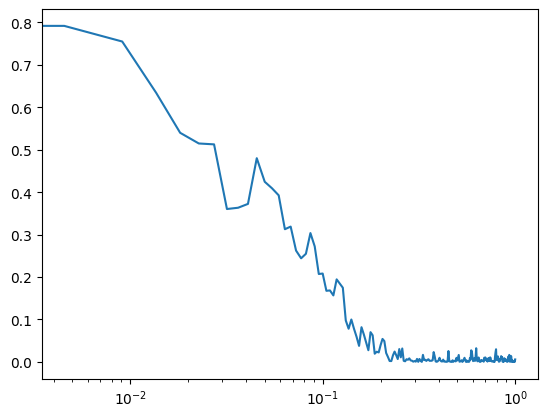

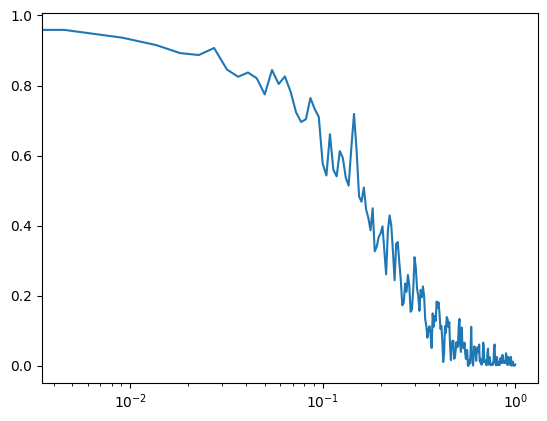

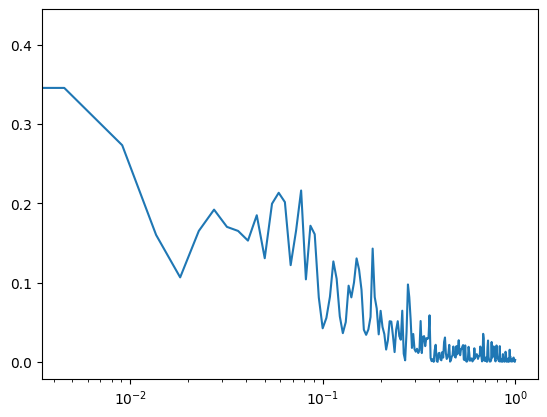

In [65]:
plt.semilogx(coh_freq_ds, coh_u_alongCross_ds[5, :])
plt.show()
plt.semilogx(coh_freq_ds, coh_v_alongCross_ds[5, :])
plt.show()
plt.semilogx(coh_freq_ds, coh_w_alongCross_ds[5, :])
plt.show()


In [66]:
def write_coherence_data_to_dat(spatial_separations, frequencies, 
                               coh_u, coh_v, coh_w, filename):
    """
    Write coherence data to a structured .dat file.
    
    Parameters
    ----------
    spatial_separations : array-like, shape (n_seps,)
        The spatial separation values
    frequencies : array-like, shape (n_freqs,)  
        The frequency values
    coh_u, coh_v, coh_w : array-like, shape (n_seps, n_freqs)
        The coherence data for u, v, w components
    filename : str
        Output filename
    """
    # Convert to numpy arrays to ensure proper indexing
    spatial_separations = np.array(spatial_separations)
    frequencies = np.array(frequencies)
    coh_u = np.array(coh_u)
    coh_v = np.array(coh_v)
    coh_w = np.array(coh_w)
    
    print(f"Writing coherence data:")
    print(f"  Spatial separations: {spatial_separations.shape}")
    print(f"  Frequencies: {frequencies.shape}")
    print(f"  Coherence arrays: {coh_u.shape}")
    print(f"  Total data points: {coh_u.size}")
    
    # Create a header with metadata
    header_lines = [
        "# Coherence data file",
        f"# Number of spatial separations: {len(spatial_separations)}",
        f"# Number of frequencies: {len(frequencies)}",
        f"# Grid dimensions: {coh_u.shape[0]} x {coh_u.shape[1]}",
        f"# Total data points: {coh_u.size}",
        "# Data format: spatial_separation frequency coh_u coh_v coh_w",
        "# Columns: sep_idx freq_idx spatial_separation frequency coh_u coh_v coh_w"
    ]
    
    # Write to file
    with open(filename, 'w') as f:
        # Write header
        for line in header_lines:
            f.write(line + '\n')
        f.write('\n')  # Empty line before data
        
        # Write column headers
        f.write(f"{'sep_idx':>7} {'freq_idx':>8} {'spatial_sep':>12} {'frequency':>12} "
                f"{'coh_u':>12} {'coh_v':>12} {'coh_w':>12}\n")
        
        # Write data directly - ensure we handle all points
        data_count = 0
        for i, sep in enumerate(spatial_separations):
            for j, freq in enumerate(frequencies):
                # Check if indices are within bounds
                if i < coh_u.shape[0] and j < coh_u.shape[1]:
                    f.write(f"{i:7d} {j:8d} "
                           f"{sep:12.6e} {freq:12.6e} "
                           f"{coh_u[i, j]:12.6e} {coh_v[i, j]:12.6e} {coh_w[i, j]:12.6e}\n")
                    data_count += 1
                else:
                    print(f"Warning: Skipping out-of-bounds indices ({i}, {j})")
        
        print(f"Successfully wrote {data_count} data points to {filename}")

# Usage example from your notebook:
write_coherence_data_to_dat(
    spatial_separations=spatialSeparation_ds,
    frequencies=coh_freq_ds,
    coh_u=coh_u_alongCross_ds,
    coh_v=coh_v_alongCross_ds,
    coh_w=coh_w_alongCross_ds,
    filename='coherence_data.dat'
)

Writing coherence data:
  Spatial separations: (24,)
  Frequencies: (221,)
  Coherence arrays: (24, 221)
  Total data points: 5304
Successfully wrote 5304 data points to coherence_data.dat
